<a href="https://colab.research.google.com/github/ShadmanRohan/huggingface-boilerplates/blob/main/text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 325 kB 4.5 MB/s 
     |████████████████████████████████| 136 kB 10.6 MB/s 
     |████████████████████████████████| 1.1 MB 8.5 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 212 kB 19.2 MB/s 
     |████████████████████████████████| 127 kB 31.9 MB/s 
     |████████████████████████████████| 144 kB 32.2 MB/s 
     |████████████████████████████████| 94 kB 456 kB/s 
     |████████████████████████████████| 271 kB 13.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 5.3 MB/s 
 

In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [8]:
from transformers import AutoModelForSequenceClassification 
from transformers import AutoTokenizer 
import torch

num_labels = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
from sklearn.metrics import accuracy_score, f1_score 
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted") 
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [11]:
from huggingface_hub import notebook_login 
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [12]:
from transformers import Trainer, TrainingArguments 
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size 
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2, 
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size, 
                                  per_device_eval_batch_size=batch_size, 
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch", 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps, 
                                  push_to_hub=True,
                                  log_level="error")

In [16]:
!sudo apt-get install git-lfs
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"], 
                  eval_dataset=emotions_encoded["validation"], 
                  tokenizer=tokenizer)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,020 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 156210 files and directories c

Cloning https://huggingface.co/Shadman/distilbert-base-uncased-finetuned-emotion into local empty directory.


In [17]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.800500,0.309505,0.902000,0.899419
2,0.242500,0.221703,0.922500,0.922765


TrainOutput(global_step=500, training_loss=0.5214699859619141, metrics={'train_runtime': 430.5238, 'train_samples_per_second': 74.328, 'train_steps_per_second': 1.161, 'total_flos': 720342861696000.0, 'train_loss': 0.5214699859619141, 'epoch': 2.0})

In [19]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_accuracy': 0.9225,
 'test_f1': 0.9227653443797317,
 'test_loss': 0.22170335054397583,
 'test_runtime': 8.3108,
 'test_samples_per_second': 240.65,
 'test_steps_per_second': 3.85}

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix 
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true") 
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()

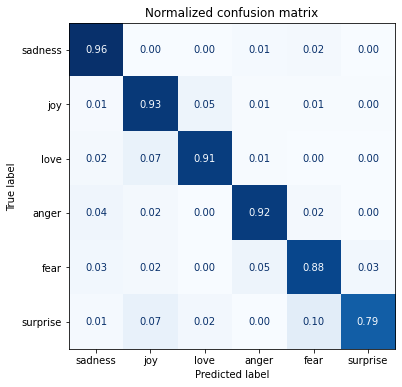

In [40]:
import numpy as np
import matplotlib.pyplot as plt

y_preds = np.argmax(preds_output.predictions, axis=1)
labels = emotions["train"].features["label"].names
y_valid = emotions_encoded["validation"]["label"]

plot_confusion_matrix(y_preds, y_valid, labels)

In [42]:
from torch.nn.functional import cross_entropy 
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model 
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}

    with torch.no_grad(): 
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                            reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns 
    return {"loss": loss.cpu().numpy(),
    "predicted_label": pred_label.cpu().numpy()}

In [43]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask","label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [45]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"] 
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str) 
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [46]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,6.123293
1963,i called myself pro life and voted for perry w...,joy,sadness,5.582761
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.453064
1509,i guess this is a memoir so it feels like that...,joy,fear,5.293839
1195,i always think about are act the way i want to...,anger,joy,5.234850
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.219186
1274,i am going to several holiday parties and i ca...,joy,sadness,5.165548
1950,i as representative of everything thats wrong ...,surprise,sadness,5.065453
1801,i feel that he was being overshadowed by the s...,love,sadness,5.056097
1581,i feel stronger clearer but a little annoyed n...,anger,joy,4.571964


In [47]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
578,i got to christmas feeling positive about the ...,joy,joy,0.016035
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.016075
1873,i feel practically virtuous this month i have ...,joy,joy,0.016100
1310,i feel like an ungrateful asshole,sadness,sadness,0.016224
1263,i feel this way about blake lively,joy,joy,0.016255
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.016468
1513,i have also been getting back into my gym rout...,joy,joy,0.016556
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.016588
69,i have no extra money im worried all of the ti...,sadness,sadness,0.016661
424,i believe everyone can feel energetic after li...,joy,joy,0.016665


In [48]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr05_19-09-10_9c559dae8caa/events.out.tfevents.1649186163.9c559dae8caa.73.0:  69%|######9   …

To https://huggingface.co/Shadman/distilbert-base-uncased-finetuned-emotion
   0ac78ce..28c25ad  main -> main

To https://huggingface.co/Shadman/distilbert-base-uncased-finetuned-emotion
   28c25ad..96fa35a  main -> main



'https://huggingface.co/Shadman/distilbert-base-uncased-finetuned-emotion/commit/28c25ad0b4e2807186a9b7e5233e8f1aa50b32e4'

In [49]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion" 
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [50]:
custom_tweet = "I saw a movie today and it was really good." 
preds = classifier(custom_tweet, return_all_scores=True)

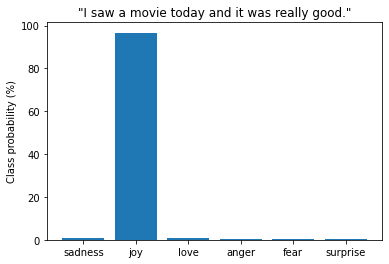

In [52]:
import pandas as pd

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()